In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import csv
import cv2
import glob
import networkx as nx
from tqdm import tqdm
from enum import Enum
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import xml.etree.ElementTree as et 
from dataset import create_dataset
from gym.envs.hyrule.hyrule_env import HyruleEnv

Loading thumbnails: 100%|██████████| 57/57 [00:10<00:00,  5.75it/s]
/Users/martinweiss/.pyenv/versions/3.5.2/lib/python3.5/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['path', 'thumbnail', 'x', 'y', 'z']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
/Users/martinweiss/.pyenv/versions/3.5.2/lib/python3.5/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->['frame', 'obj_type', 'house_number', 'label_coords']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [3]:
graph_path="data/saint-urbain/processed/graph.pkl"

In [4]:
env = HyruleEnv()

In [5]:
obs = env.reset()

In [6]:
start_node = np.random.choice(len(env.G.nodes))
edges = [edge[1] for edge in list(env.G.edges(start_node))]
next_node = np.random.choice(edges)

In [7]:
pos = {k: v.get("coords")[0:2] for k, v in env.G.nodes(data=True)}

In [17]:
edge_angles = {}
cur_coords = env.G.nodes[env.agent_pos]['coords']
print(cur_coords)
for _, sink in env.G.edges(env.agent_pos):
    print(sink)
    sink_coords = env.G.nodes[sink]['coords']
    print(sink_coords)
    a = sink_coords[0] - cur_coords[0]
    o = sink_coords[1] - cur_coords[1]
    h = np.linalg.norm(env.G.nodes[sink]['coords'][0:2] - env.G.nodes[env.agent_pos]['coords'][0:2])
    print("a: " + str(a))
    print("o: " + str(o))
    print("h: " + str(h))
    print("o/h: " + str(o/h))
    angle = np.arcsin(o/h)/np.pi
    print(angle)
    edge_angles[sink] = np.abs(env.agent_dir - angle)

[-0.83925764  4.19221927  0.39473514]
33
[-0.90802662  4.71103969  0.44626134]
a: -0.06876897576503038
o: 0.5188204217847963
h: 0.5233581967340583
o/h: 0.9913295043861369
0.45805295400237017
41
[-0.74041165  3.66047852  0.3251471 ]
a: 0.09884598977495718
o: -0.5317407511497092
h: 0.5408500310879606
o/h: -0.9831574754282117
-0.4414967271921756


In [18]:
next_agent_pos = min(edge_angles, key=edge_angles.get)

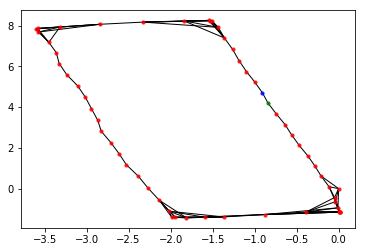

In [19]:
nx.draw_networkx_nodes(env.G, pos,
                       nodelist=env.G.nodes - {env.agent_pos, next_agent_pos},
                       node_color='r',
                       node_size=10,
                   alpha=0.8)
nx.draw_networkx_nodes(env.G, pos,
                       nodelist={env.agent_pos},
                       node_color='g',
                       node_size=10,
                   alpha=0.8)
nx.draw_networkx_nodes(env.G, pos,
                       nodelist={next_agent_pos},
                       node_color='b',
                       node_size=10,
                   alpha=0.8)
edges = nx.draw_networkx_edges(env.G, pos=pos)


In [26]:
env.data_df[['frame', 'path', 'x', 'y', 'z']]

,frame,path,x,y,z
0,58,data/saint-urbain/panos/pano_frame_000046.png,0,0,0
1,53,data/saint-urbain/panos/pano_frame_000052.png,-0.387054,-1.15028,-0.0782525
2,52,data/saint-urbain/panos/pano_frame_000053.png,-0.877851,-1.2731,-0.0523119
3,51,data/saint-urbain/panos/pano_frame_000047.png,-1.36923,-1.39047,-0.0510517
4,50,data/saint-urbain/panos/pano_frame_000051.png,-1.58562,-1.4096,-0.0515526
5,49,data/saint-urbain/panos/pano_frame_000045.png,-1.81123,-1.43192,-0.017543
6,48,data/saint-urbain/panos/pano_frame_000044.png,-1.9448,-1.4026,-0.00299101
7,47,data/saint-urbain/panos/pano_frame_000050.png,-1.98467,-1.41524,-0.00260346
8,46,data/saint-urbain/panos/pano_frame_000054.png,-2.01726,-1.11058,-0.0190359
9,45,data/saint-urbain/panos/pano_frame_000040.png,-2.13301,-0.57684,0.0353872


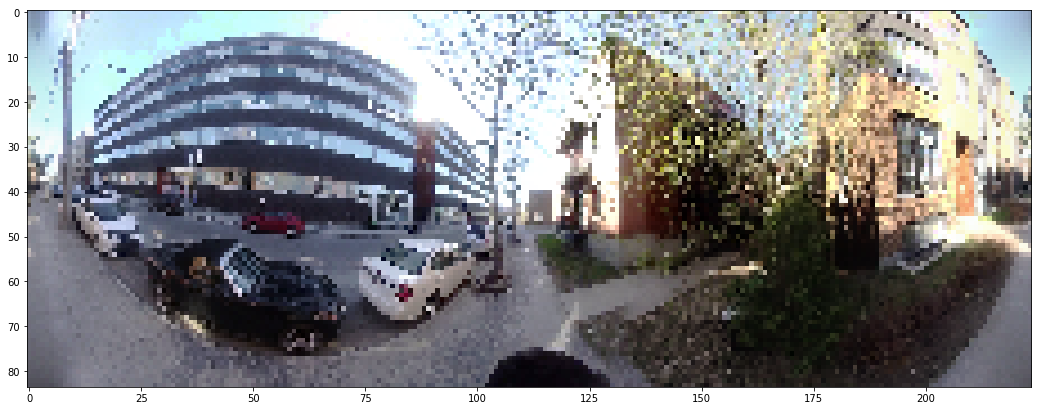

In [22]:
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(env.data_df.iloc[env.G.nodes[env.agent_pos]['frame']].thumbnail)
plt.show()


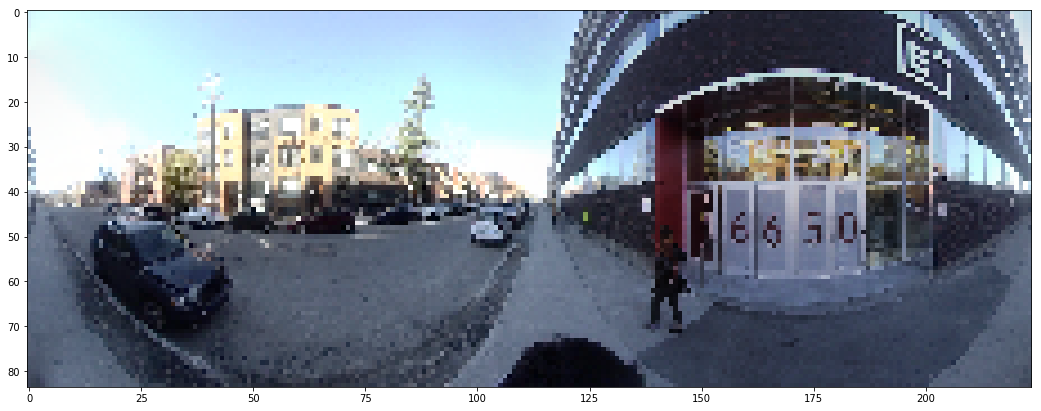

In [24]:
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(env.data_df.iloc[next_agent_pos].thumbnail)
plt.show()